# FUNCTIONS

In [1]:
def get_file_size(file_path):
  size = os.path.getsize(file_path)
  return size

In [2]:
def convert_bytes(size, unit=None):
  if unit == "KB":
    return print('File size: ' + str(round(size/1024,3)) + ' kilobytes')
  elif unit == "MB":
    return print('File size: ' + str(round(size/(1024*1024),3)) + ' Megabytes')
  else:
    return print('File size: ' + str(size) + ' bytes') 

# IMPORTING PACKAGES

In [3]:
# TRAINING
from tensorflow.keras.layers import AveragePooling2D,Flatten,Dropout,Dense,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# VIDEO PLAYBACK
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
from playsound import playsound
import imutils
import time
import cv2
from plyer import notification


# DATA PREPROCESSING

In [49]:
INIT_LR = 0.0001
EPOCHS = 30
BS = 33

In [50]:
dataset=r'C:\Users\shubh\anaconda3\envs\PROJECT\FACEMASK DETECTION\dataset'
imagePaths = list(paths.list_images(dataset))

In [51]:
# Load dataset
data=[]
labels=[]

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    
    image = load_img(imagePath, target_size=(96,96))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    data.append(image)
    labels.append(label)

In [52]:
data = np.array(data, dtype="float32")   # convert the data and labels to NumPy arrays
labels = np.array(labels)

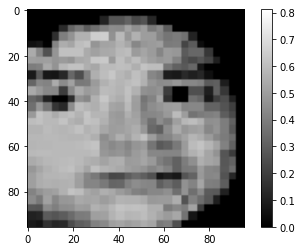

In [53]:
plt.figure()
plt.imshow(data[88],cmap="gray")
plt.colorbar()
plt.grid(False)
plt.show()

In [54]:
lb = LabelBinarizer()  # perform one-hot encoding on the labels
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [55]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [56]:
len(data)

800

In [57]:
trainX.shape

(640, 96, 96, 3)

In [58]:
aug = ImageDataGenerator(horizontal_flip=True)

# ML MODEL - USING MobileNetV2

In [59]:
baseModel = MobileNetV2(input_shape=(96,96,3),alpha=0.35,weights="imagenet",include_top=False,input_tensor=Input(shape=(96, 96, 3)))

In [60]:
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten(input_shape=(128,128))(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [61]:
for layer in baseModel.layers:
    layer.trainable = False

In [62]:
print("COMPILING MAIN MODEL...")
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

H = model.fit(trainX, trainY, steps_per_epoch=len(trainX) // BS, 
          validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)

COMPILING MAIN MODEL...
Epoch 1/30
19/19 [==============================] - 7s 159ms/step - loss: 0.6463 - accuracy: 0.6718 - val_loss: 0.4983 - val_accuracy: 0.7812
Epoch 2/30
19/19 [==============================] - 2s 104ms/step - loss: 0.4375 - accuracy: 0.8335 - val_loss: 0.4230 - val_accuracy: 0.8500
Epoch 3/30
19/19 [==============================] - 2s 116ms/step - loss: 0.3823 - accuracy: 0.8735 - val_loss: 0.3790 - val_accuracy: 0.8438
Epoch 4/30
19/19 [==============================] - 3s 149ms/step - loss: 0.3554 - accuracy: 0.8760 - val_loss: 0.3509 - val_accuracy: 0.8500
Epoch 5/30
19/19 [==============================] - 3s 150ms/step - loss: 0.2935 - accuracy: 0.9182 - val_loss: 0.3405 - val_accuracy: 0.8562
Epoch 6/30
19/19 [==============================] - 3s 140ms/step - loss: 0.2995 - accuracy: 0.8930 - val_loss: 0.3207 - val_accuracy: 0.8875
Epoch 7/30
19/19 [==============================] - 3s 151ms/step - loss: 0.2498 - accuracy: 0.9356 - val_loss: 0.3102 - val

In [63]:
print("EVALUATING NETWORK...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

EVALUATING NETWORK...


In [64]:
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.88      0.91      0.90        80
without_mask       0.91      0.88      0.89        80

    accuracy                           0.89       160
   macro avg       0.89      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160



In [65]:
print("SAVING MASK DETECTION MODEL...")
model.save(r'C:\Users\shubh\anaconda3\envs\PROJECT\FACEMASK DETECTION\model.h5',model)

SAVING MASK DETECTION MODEL...


In [66]:
KERAS_MODEL_NAME="model.h5"

In [67]:
convert_bytes(get_file_size(r'C:\Users\shubh\anaconda3\envs\PROJECT\FACEMASK DETECTION\model.h5'),"MB")

File size: 2.048 Megabytes


# TENSORFLOW LITE CONVERSION

In [68]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [69]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations=[tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
#tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
#tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\shubh\AppData\Local\Temp\tmpnfjm0ok6\assets


INFO:tensorflow:Assets written to: C:\Users\shubh\AppData\Local\Temp\tmpnfjm0ok6\assets


In [70]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

597904

In [71]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

File size: 583.891 kilobytes


# FACEMASK DETECTION VIDEO

In [27]:
def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),(104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()

    # initialize our list of faces, their corresponding locations, and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is greater than the minimum confidence
        if confidence > args["confidence"]:
            # compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # extract the face ROI, convert it from BGR to RGB channel ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            # add the face and bounding boxes to their respective lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all* faces at the same time rather than one-by-one predictions in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    # return a 2-tuple of the face locations and their corresponding locations
    return (locs, preds)

In [ ]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-f", "--face", type=str,
    default="face_detector",
    help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
    default="mask_detector.model",
    help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
    help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

In [ ]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],
    "res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

In [ ]:
# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model(args["model"])

In [ ]:
# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)

In [ ]:
# loop over the frames from the video stream
while True:
    # grab the frame from the threaded video stream and resize it to have a maximum width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width=400)

    # detect faces in the frame and determine if they are wearing a face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

    # loop over the detected face locations and their corresponding locations
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        # determine the class label and color we'll use to draw the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        if label == "No Mask":
            notification.notify(
                title = "***No Mask Detected***",
                        message = "Wear Mask to stay safe! ",
                        app_icon = "images/1.ico",    #ico file should be downloaded
                        timeout = 1
                    )


        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # display the label and bounding box rectangle on the output frame
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

        # Alarm when "No Mask" detected
        if mask < withoutMask:
            path = os.path.abspath("Alarm.wav")
            playsound(path)

    # show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()